# **Project 2: Understanding calibration in CNNs**

***Olga Bonachera del Pozo, Daniel Kwapien, Alejandro Sánchez***

*Grado en Ciencia e Ingeniería de Datos, grupo 96*

In [ ]:
import time
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import PIL
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Download and prepare dataset

We are asked to create a classifier to classify birds from cats in CIFAR10, considering only these two categories.

In order to achieve this, first we download the original CIFAR10 dataset.

In [ ]:
from torchvision import datasets, transforms, utils, models

trainset = datasets.CIFAR10(root='./data', train=True, download=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True)

classes = {
    '0': 'bird',
    '1': 'cat'
}

Files already downloaded and verified
Files already downloaded and verified


Then we create our own PyTorch dataset selecting the desired classes and assigning it the corresponding label

In [ ]:
class BirdsAndCatsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.data = []
        self.targets = []
        self.transform = transform
        bird_class = 2
        cat_class = 3
        for i, (image, label) in enumerate(dataset):
            if label==bird_class or label==cat_class:
                self.data.append(np.array(image))
                self.targets.append(label - 2)

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = PIL.Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

birds_and_cats_trainset = BirdsAndCatsDataset(trainset, transform=train_transform)
birds_and_cats_testset = BirdsAndCatsDataset(testset, transform=test_transform)

In [ ]:
print(f"Length of birds_and_cats_train: {len(birds_and_cats_trainset)}")
print(f"Length of birds_and_cats_test: {len(birds_and_cats_testset)}")

Length of birds_and_cats_train: 10000
Length of birds_and_cats_test: 2000


Finally we create the Data Loader for the trainset and the testset.

In [ ]:
import copy

trainloader = torch.utils.data.DataLoader(birds_and_cats_trainset, batch_size=64,shuffle=True, num_workers=2)
validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:9000,:,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:9000]

validloader.dataset.data = validloader.dataset.data[9000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[9000:]

testloader = torch.utils.data.DataLoader(birds_and_cats_testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

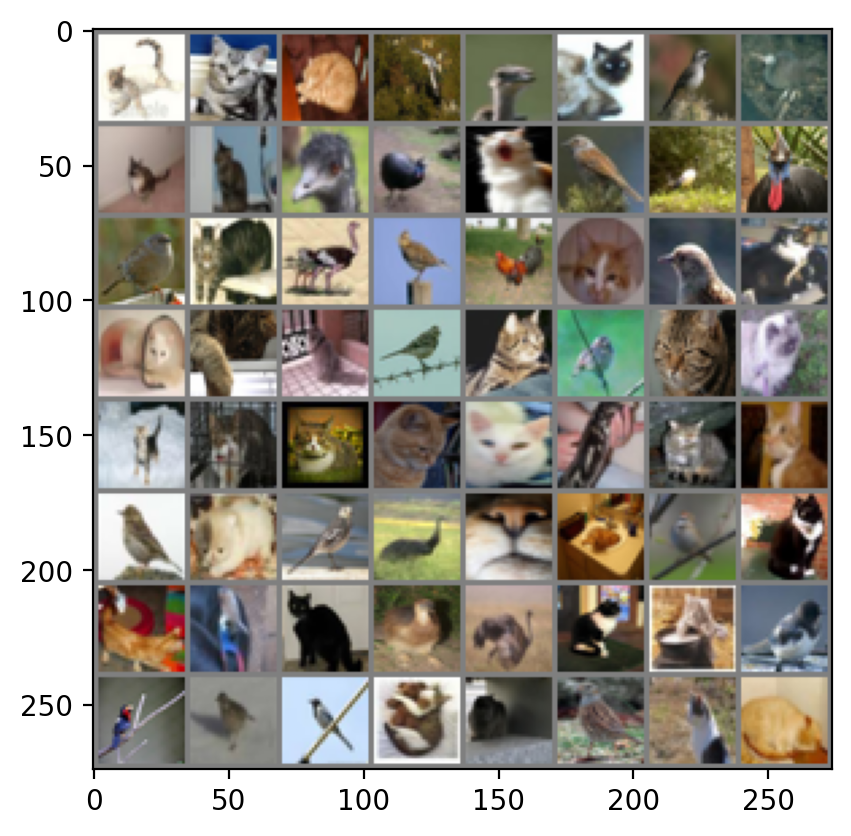

In [ ]:
traindata = iter(trainloader)
images, labels = next(traindata)

imshow(utils.make_grid(images))

In [ ]:
import matplotlib.pyplot as plt

def show_sample(dataloader, n_images=10, figsize=(14, 5)):
  """
  This function displays a sample image and its corresponding label from a PyTorch dataloader.

  Args:
      dataloader: A PyTorch dataloader object.
  """

  images, labels = next(iter(dataloader))
  n_images = min(n_images, len(images))

  fig, axes = plt.subplots(nrows=2, ncols=int(n_images/2), figsize=figsize)

  for i in range(n_images):
    ax = axes.flat[i]
    img = images[i,:,:,:]/2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)))

    label = labels.detach().numpy()[i]
    ax.set_title(f"Label: {label}. Class: {classes[str(label)]}")
    ax.axis('off')

  fig.suptitle(f"{n_images} Samples from DataLoader", fontsize=18)
  plt.tight_layout()
  plt.show()

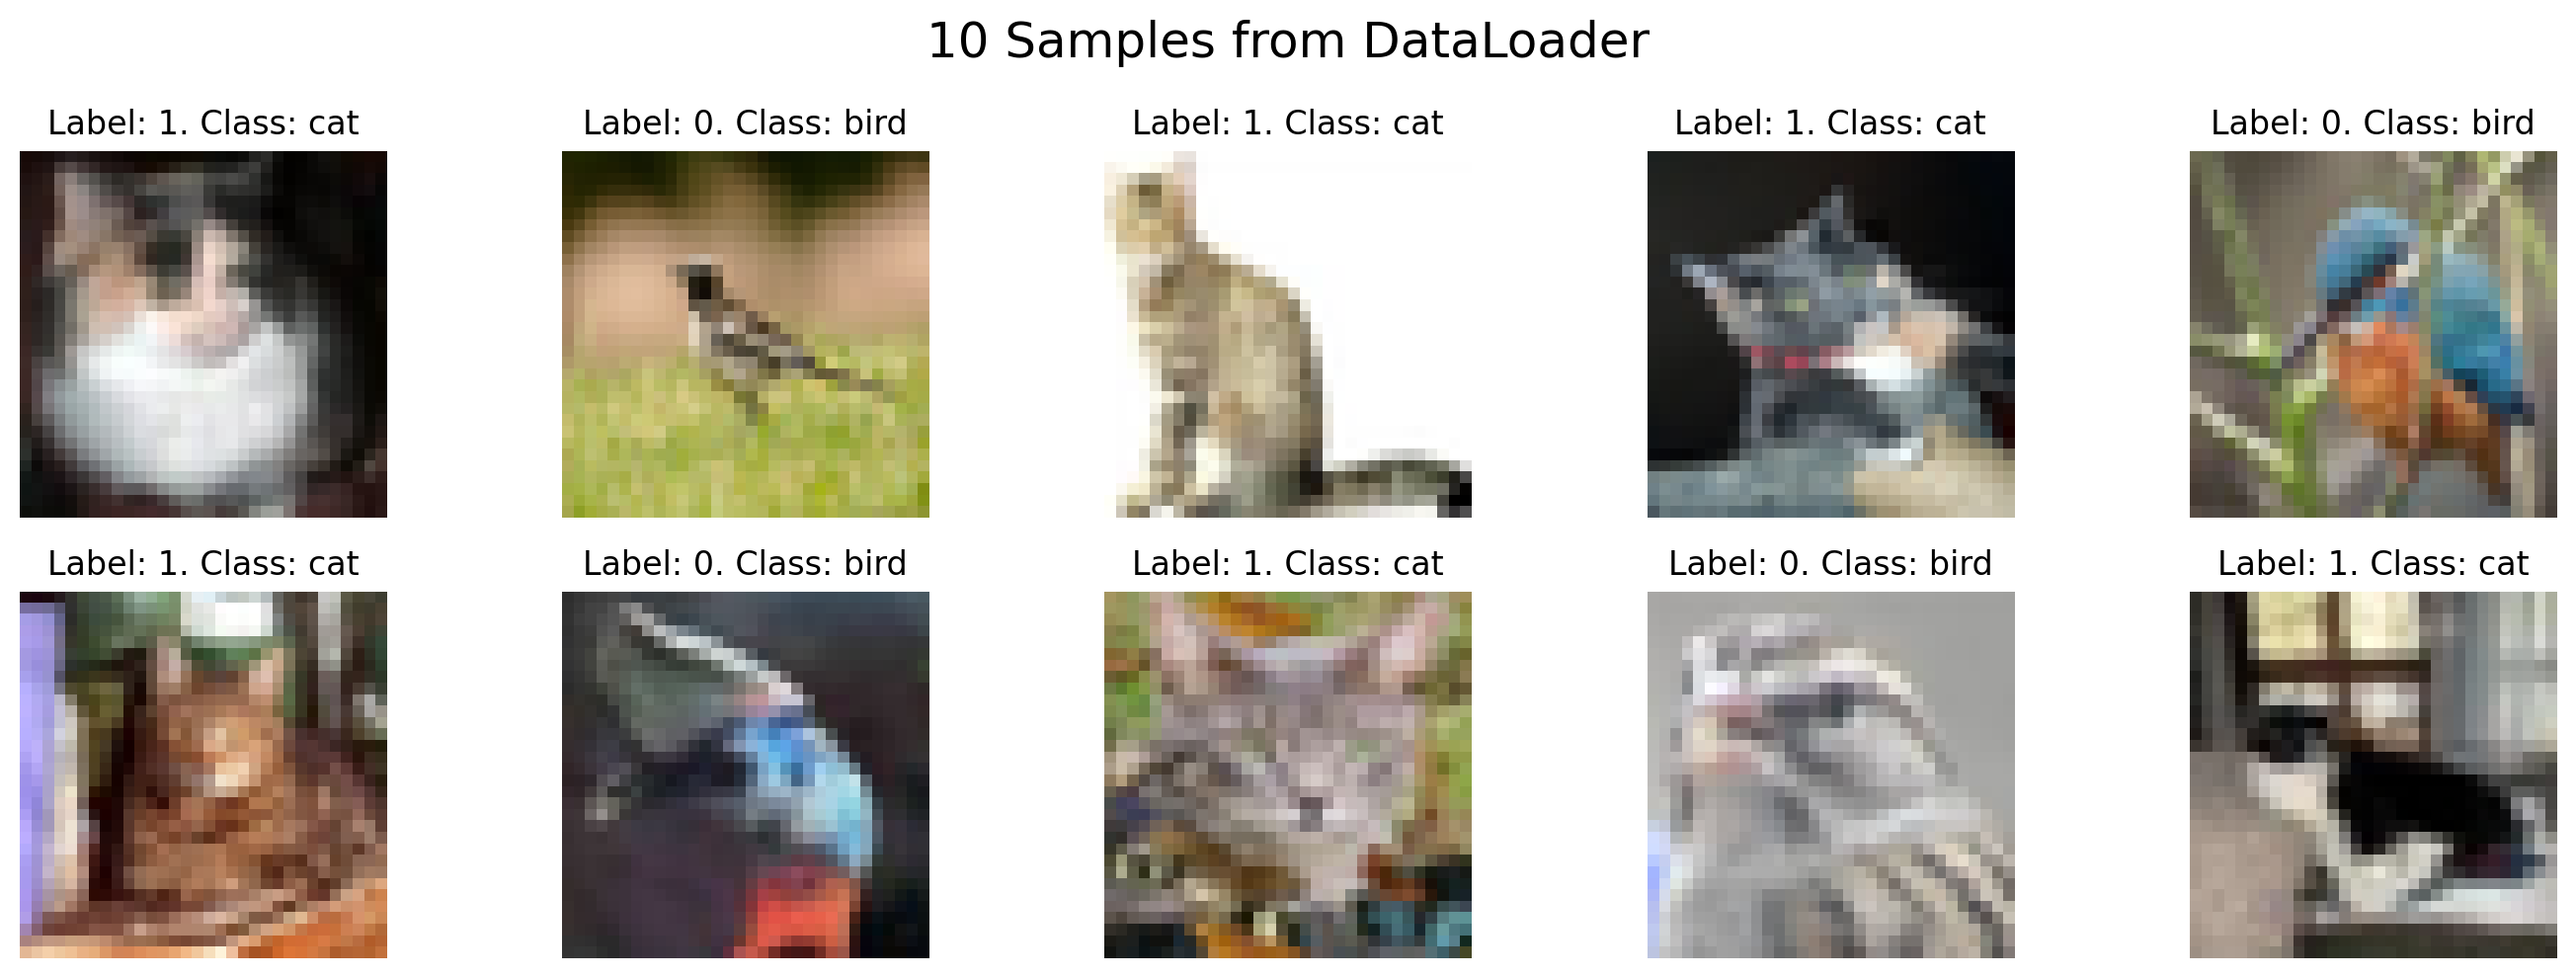

In [ ]:
show_sample(trainloader)

## 2. Train a LeNet5 and evaluate the confidence calibration

In [ ]:
Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

While we are implementing LeNet5 for our problem we have to take into account:

* The output of the output layer has to be 2, since we have 2 classes.
* We could use either a Sigmoid or a SoftMax function.

In [ ]:
class Lenet5(nn.Module):

  def __init__(self, dimx, nlabels, prob):

    super().__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,padding=0)

    # Max Pooling layer
    self.pool = nn.MaxPool2d(2,2)

    # Dense Layers
    self.linear1 = nn.Linear(400,120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn.Linear(84, 2)

    # Tanh activation function
    self.relu = nn.ReLU()

    # Softmax activation function
    self.softmax = nn.Softmax(dim=1)

    # Dropout module
    self.dropout = nn.Dropout(p=prob)

    # Batch normalization layers
    self.BN1 = nn.BatchNorm2d(num_features=6)
    self.BN2 = nn.BatchNorm2d(num_features=16)
    self.BN3 = nn.BatchNorm1d(120)

    # Spatial dimension of the output tensor of the 2nd convolutional layer.
    self.final_dim = int(((dimx-4)/2-4)/2)

  def forward(self, x):

    x = self.conv1(x)
    x = self.BN1(x)
    x = self.relu(x)

    x = self.pool(x)

    x = self.conv2(x)
    x = self.BN2(x)
    x = self.relu(x)

    x = self.pool(x)
    x = self.dropout(x)

    x = x.view(-1, 16*self.final_dim**2)

    x = self.linear1(x)
    x = self.BN3(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.linear3(x)

    return x


In the extended class of our LeNet5 network we will implement the trainloop, evaluate performance and evaluate calibration function.

The evaluate calibration function consists storing the true labels and the probabilities for label 1, let consider it as our positive class. Then we will use sklearn's function [calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) function since with the *quantile* strategy since it assigns to each bin the same number of samples. Finally we compute the average of the error between the accuracy and confidence for all bins, which is our **Expected Calibration Error (ECE)**

In [ ]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

class Lenet5_extended(Lenet5):

  def __init__(self, dimx, nlabels, prob, epochs=100, lr=0.001, calibration_evaluation=None):

    super().__init__(dimx, nlabels, prob)

    self.lr = lr
    self.optim = optim.Adam(self.parameters(), self.lr)
    self.epochs = epochs
    self.criterion = nn.CrossEntropyLoss()

    self.loss_during_training = []
    self.valid_loss_during_training = []

    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

    self.calibration = calibration_evaluation(self)

  def trainloop(self, trainloader, validloader):

    self.train()

    for e in range(int(self.epochs)):

      start_time = time.time()

      running_loss = 0.

      for images, labels in trainloader:

        images, labels = images.to(self.device), labels.to(self.device)

        self.optim.zero_grad()

        out = self.forward(images)

        loss = self.criterion(out, labels)

        running_loss += loss.item()

        loss.backward()

        self.optim.step()

      self.loss_during_training.append(running_loss/len(trainloader))

      with torch.no_grad():

        self.eval()

        running_loss = 0.

        for images, labels in validloader:

          images, labels = images.to(self.device), labels.to(self.device)

          out = self.forward(images)

          loss = self.criterion(out, labels)

          running_loss += loss.item()

        self.valid_loss_during_training.append(running_loss/len(validloader))

      self.train()

      if(e % 1 == 0):

        print(f'Epoch {e}. Training loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}. Time per epoch {time.time() - start_time} seconds')


  def eval_performance(self, dataloader):

    loss = 0
    accuracy = 0

    self.eval()

    with torch.no_grad():

      for images, labels in dataloader:
        images, labels = images.to(self.device), labels.to(self.device)
        probs = self.forward(images)

        top_p, top_class = probs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))

      self.train()
      return accuracy/len(dataloader)



In [ ]:
class Calibration_evaluation:

  def __init__(self, model):

    self.model = model

  def compute_probs(self, dataloader):

      with torch.no_grad():

        self.model.eval()

        y_true = np.array([])
        y_prob = np.array([[0,0]])

        for images, labels in dataloader:
          images = images.to(self.model.device)
          y_true = np.append(y_true, labels)
          y_prob = np.append(y_prob, self.model.softmax(self.model(images)).detach().numpy(), axis=0)

        y_prob = y_prob[1:]

        return y_true, y_prob

  def plot_reliabilitydiagram(self, dataloader, M=10):

    with torch.no_grad():

      self.model.eval()

      y_true, y_prob = self.compute_probs(dataloader)
      y_prob = y_prob[:,1]

      prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=M, strategy='uniform')

      plt.figure()

      plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Ideal')
      plt.plot(prob_pred, prob_true ,marker='.', color='r', label='Model Calibration')
      plt.bar(prob_pred, prob_true, width=1/M, alpha=0.9, color='b', label='Model Calibration Bins')

      plt.xlabel('Confidence')
      plt.ylabel('Accuracy')
      plt.title('Calibration Curve')

      plt.xlim(0, 1)
      plt.xticks(np.arange(0, 1, 0.1))
      plt.legend()
      plt.grid(True)
      plt.show()

      return

  def expected_calibration_error(self, dataloader, M=5):

      with torch.no_grad():

        self.model.eval()

        y_true, y_prob = self.compute_probs(dataloader)
        bin_boundaries = np.linspace(0, 1, M + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        confidences = np.max(y_prob, axis=1)
        y_pred = np.argmax(y_prob, axis=1)

        accuracies = y_pred==y_true

        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):

            bin = np.where((confidences > bin_lower.item()) & (confidences <= bin_upper.item()))[0]

            if len(bin) > 0:

                accuracy_in_bin = accuracies[bin].mean()
                avg_confidence_in_bin = confidences[bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * (len(bin)/len(confidences))

        return ece


In [ ]:
my_CNN = Lenet5_extended(dimx=32,nlabels=2,prob=0.5,epochs=5,lr=1e-3, calibration_evaluation=Calibration_evaluation)
my_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.6154425879742237. Validation loss: 0.5112485084682703. Time per epoch 6.718217372894287 seconds
Epoch 1. Training loss: 0.5259400840769423. Validation loss: 0.49085041508078575. Time per epoch 5.324782371520996 seconds
Epoch 2. Training loss: 0.5054378078338948. Validation loss: 0.4657840058207512. Time per epoch 6.537523508071899 seconds
Epoch 3. Training loss: 0.48933885389185966. Validation loss: 0.45578092709183693. Time per epoch 5.271805763244629 seconds
Epoch 4. Training loss: 0.4769832861761675. Validation loss: 0.436563802883029. Time per epoch 6.473962306976318 seconds


Train accuracy:  0.8200133
Validation accuracy:  0.8083984
Test accuracy:  0.79296875


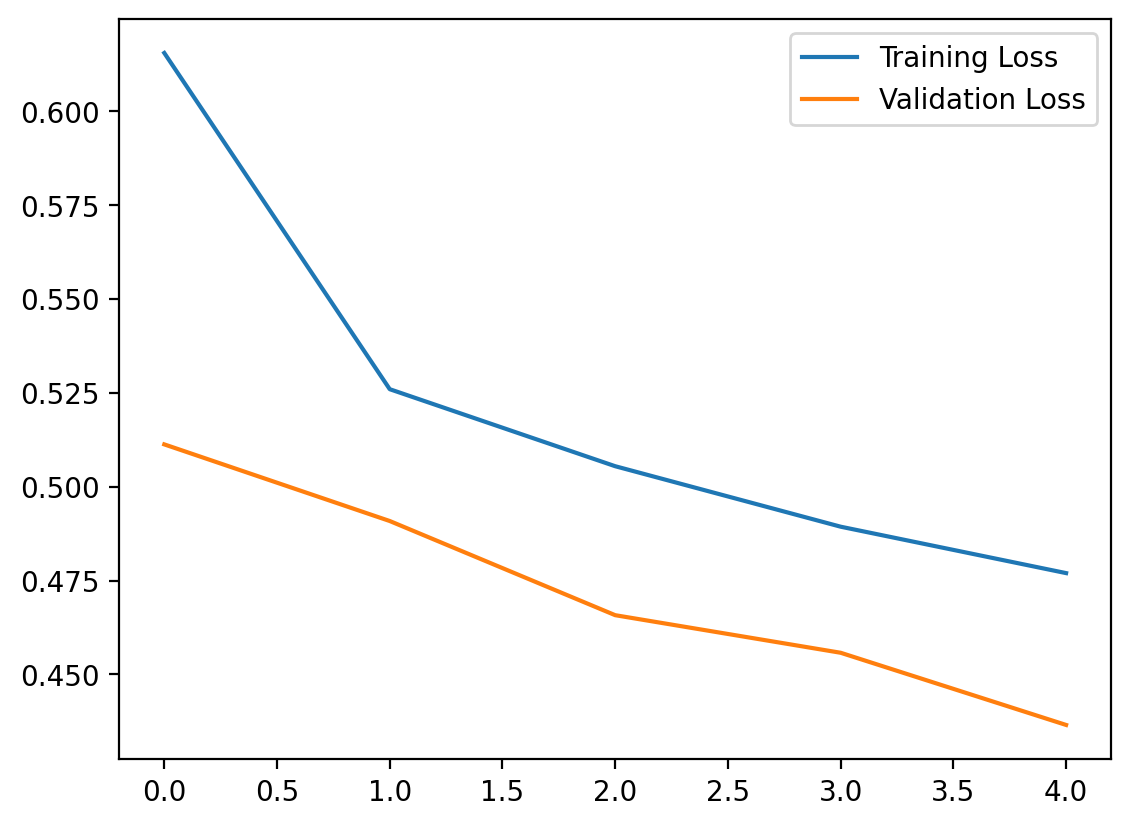

In [ ]:
plt.plot(my_CNN.loss_during_training,label='Training Loss')
plt.plot(my_CNN.valid_loss_during_training,label='Validation Loss')
plt.legend()

print('Train accuracy: ', my_CNN.eval_performance(trainloader).detach().numpy())
print('Validation accuracy: ', my_CNN.eval_performance(validloader).detach().numpy())
print('Test accuracy: ', my_CNN.eval_performance(testloader).detach().numpy())

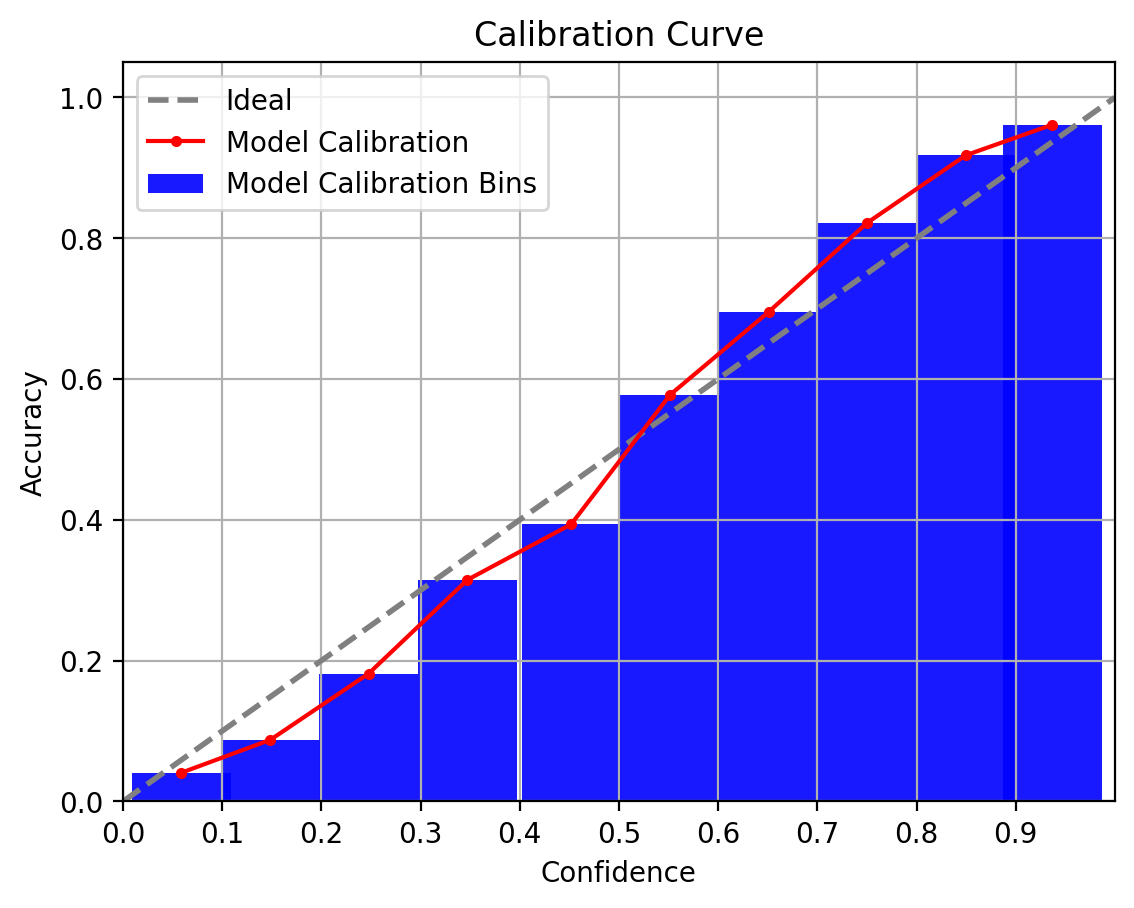

In [ ]:
my_CNN.calibration.plot_reliabilitydiagram(trainloader, M=10)

In [ ]:
ece = my_CNN.calibration.expected_calibration_error(trainloader,M=15)
print(ece)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.04806870353884165


## 3. Implement Platt's scaling

In [ ]:
class Tempscaling(nn.Module):

  def __init__(self, model, calibration_evaluation, temperature=1):

    super().__init__()

    self.model = model
    self.calibration = calibration_evaluation(self)
    self.temperature = nn.Parameter(torch.ones(1) * temperature)
    self.softmax = model.softmax
    #self.logsoftmax = model.logsoftmax
    self.device = model.device



  def forward(self, x):

    x = self.model(x)
    x = self.temperature_scale(x)

    return x

  def temperature_scale(self, logits):

    temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return torch.div(logits, temperature)


  def compute_probs(self, dataloader):

      with torch.no_grad():

        self.eval()

        y_true = np.array([])
        y_prob = np.array([[0,0]])

        for images, labels in dataloader:
          images = images.to(self.device)
          y_true = np.append(y_true, labels)
          y_prob = np.append(y_prob, self.softmax(self.forward(images)).detach().numpy(), axis=0)

        y_prob = y_prob[1:]

        return y_true, y_prob

  def plot_reliabilitydiagram(self, dataloader, M=10):

    with torch.no_grad():

      self.eval()

      y_true, y_prob = self.compute_probs(dataloader)
      y_prob = y_prob[:,1]

      prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=M, strategy='uniform')

      plt.figure()

      plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Ideal')
      plt.plot(prob_pred, prob_true ,marker='.', color='r', label='Model Calibration')
      plt.bar(prob_pred, prob_true, width=1/M, alpha=0.9, color='b', label='Model Calibration Bins')

      plt.xlabel('Confidence')
      plt.ylabel('Accuracy')
      plt.title('Calibration Curve')

      plt.xlim(0, 1)
      plt.xticks(np.arange(0, 1, 0.1))
      plt.legend()
      plt.grid(True)
      plt.show()

      return

  def expected_calibration_error(self, dataloader, M=5):

      with torch.no_grad():

        self.eval()

        y_true, y_prob = self.compute_probs(dataloader)
        bin_boundaries = np.linspace(0, 1, M + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        confidences = np.max(y_prob, axis=1)
        y_pred = np.argmax(y_prob, axis=1)

        accuracies = y_pred==y_true

        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):

            bin = np.where((confidences > bin_lower.item()) & (confidences <= bin_upper.item()))[0]

            if len(bin) > 0:
                accuracy_in_bin = accuracies[bin].mean()
                avg_confidence_in_bin = confidences[bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * (len(bin)/len(confidences))
        return ece

-------------- Training for temperature = 0.5 --------------


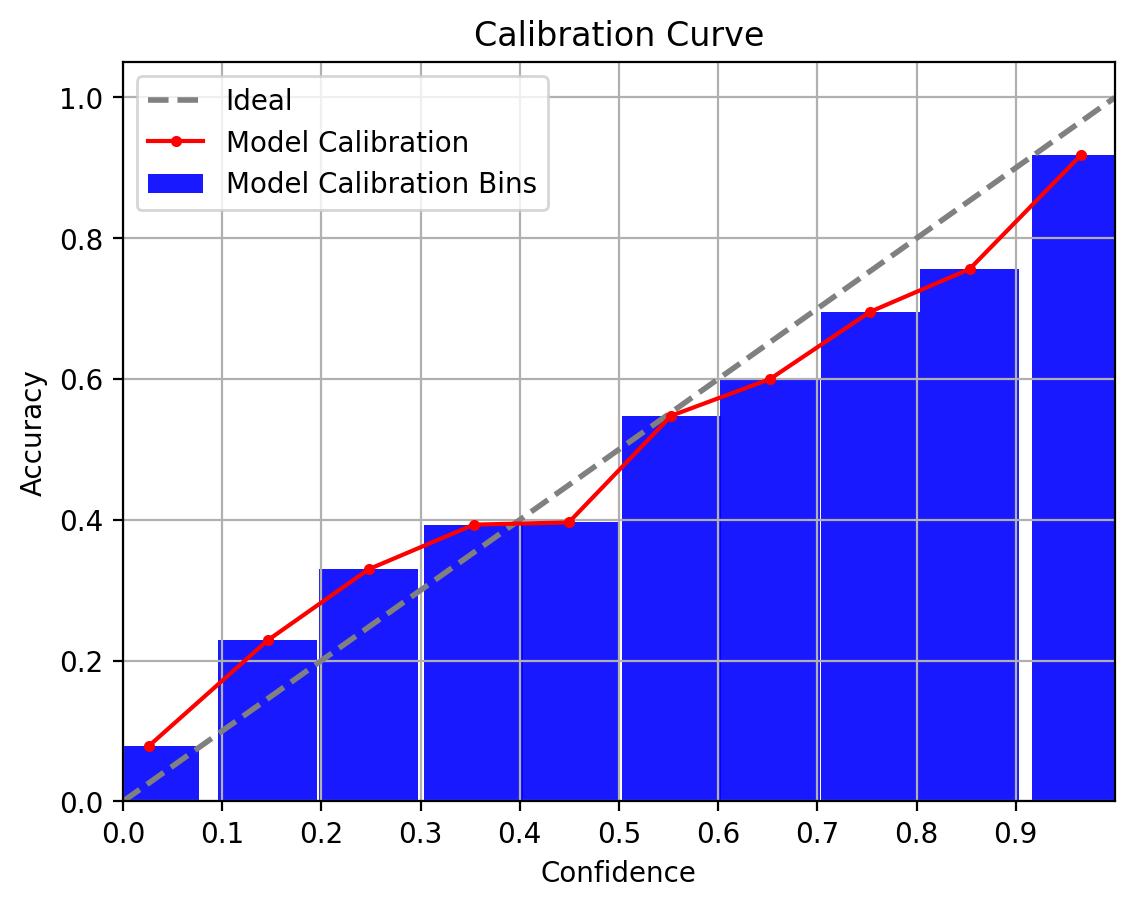

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.05643699741363525
----------------------------------------------------------------------
-------------- Training for temperature = 0.6 --------------


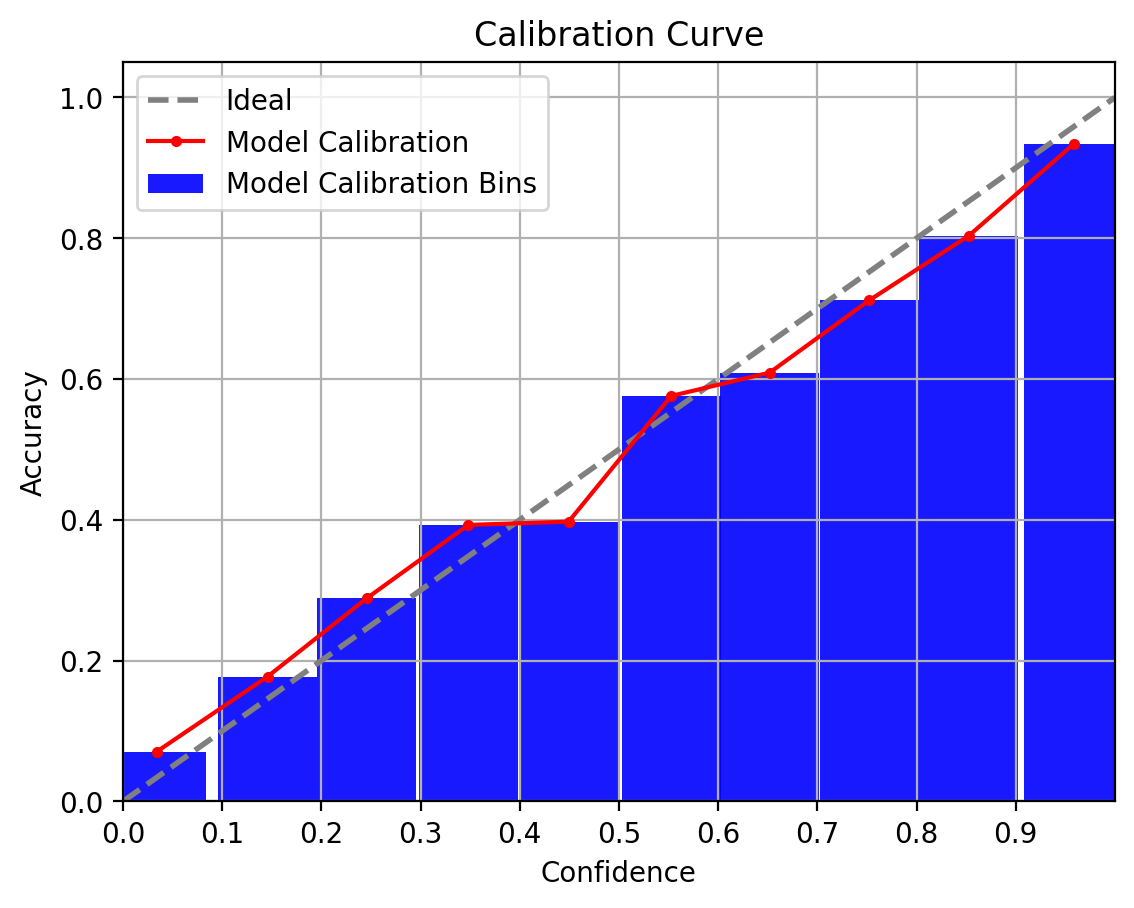

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.0361188234024578
----------------------------------------------------------------------
-------------- Training for temperature = 0.7 --------------


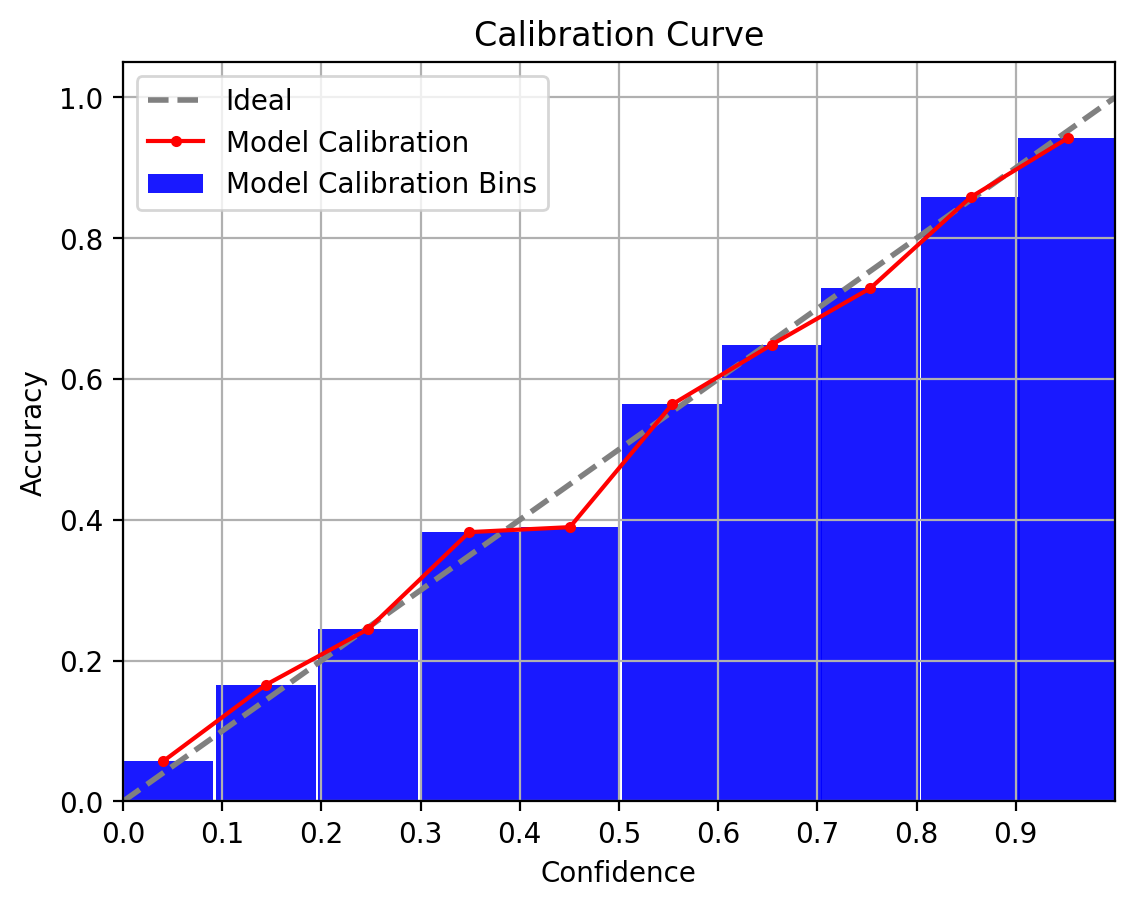

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.016297105073928852
----------------------------------------------------------------------
-------------- Training for temperature = 0.8 --------------


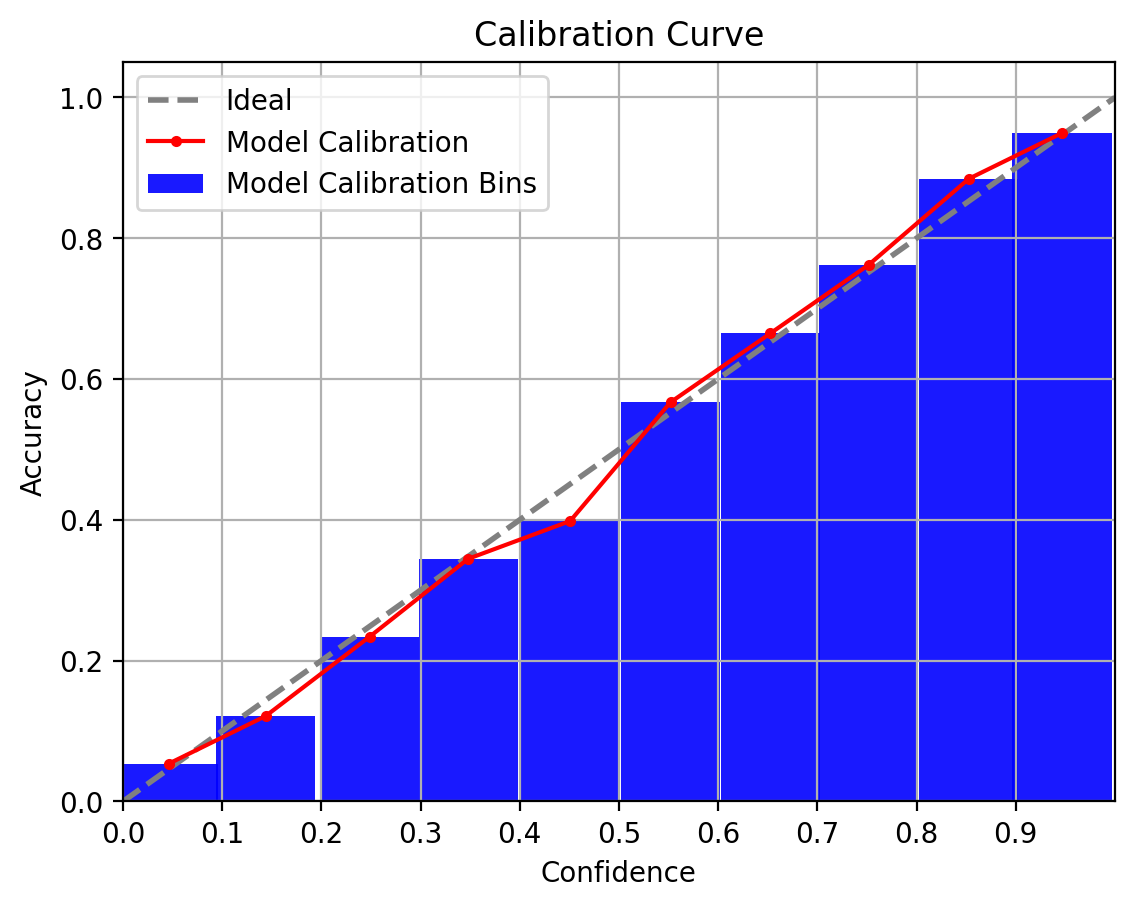

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.015038559847407887
----------------------------------------------------------------------
-------------- Training for temperature = 0.9 --------------


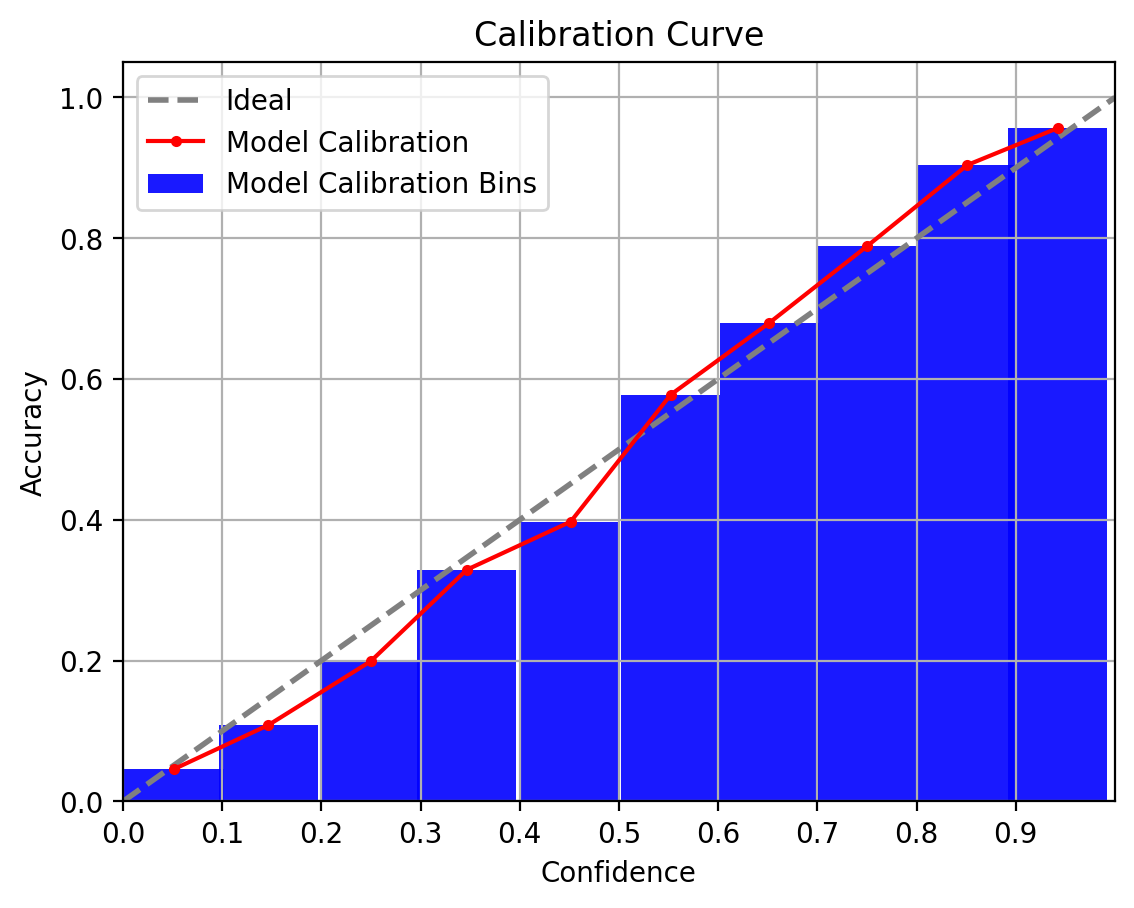

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.031109975086318103
----------------------------------------------------------------------
-------------- Training for temperature = 1.0 --------------


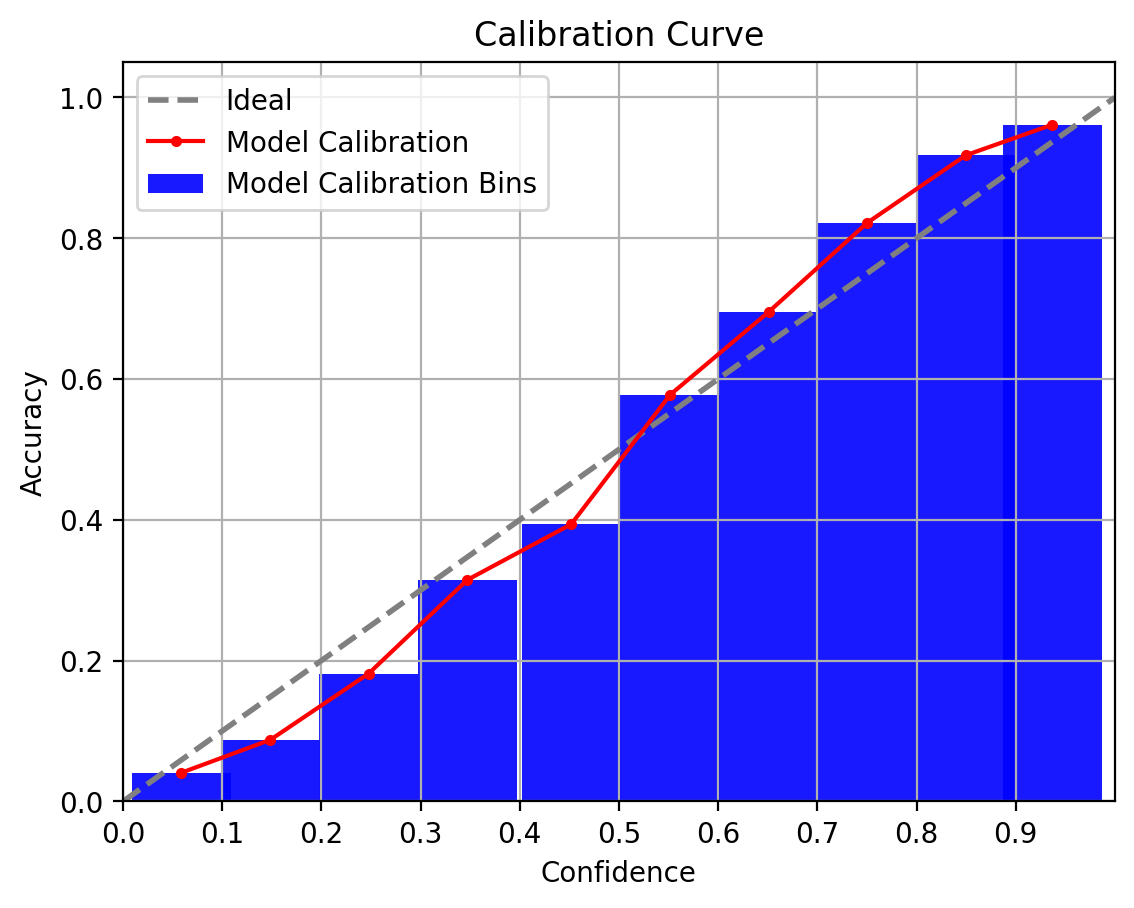

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.04806870353884166
----------------------------------------------------------------------
-------------- Training for temperature = 1.25 --------------


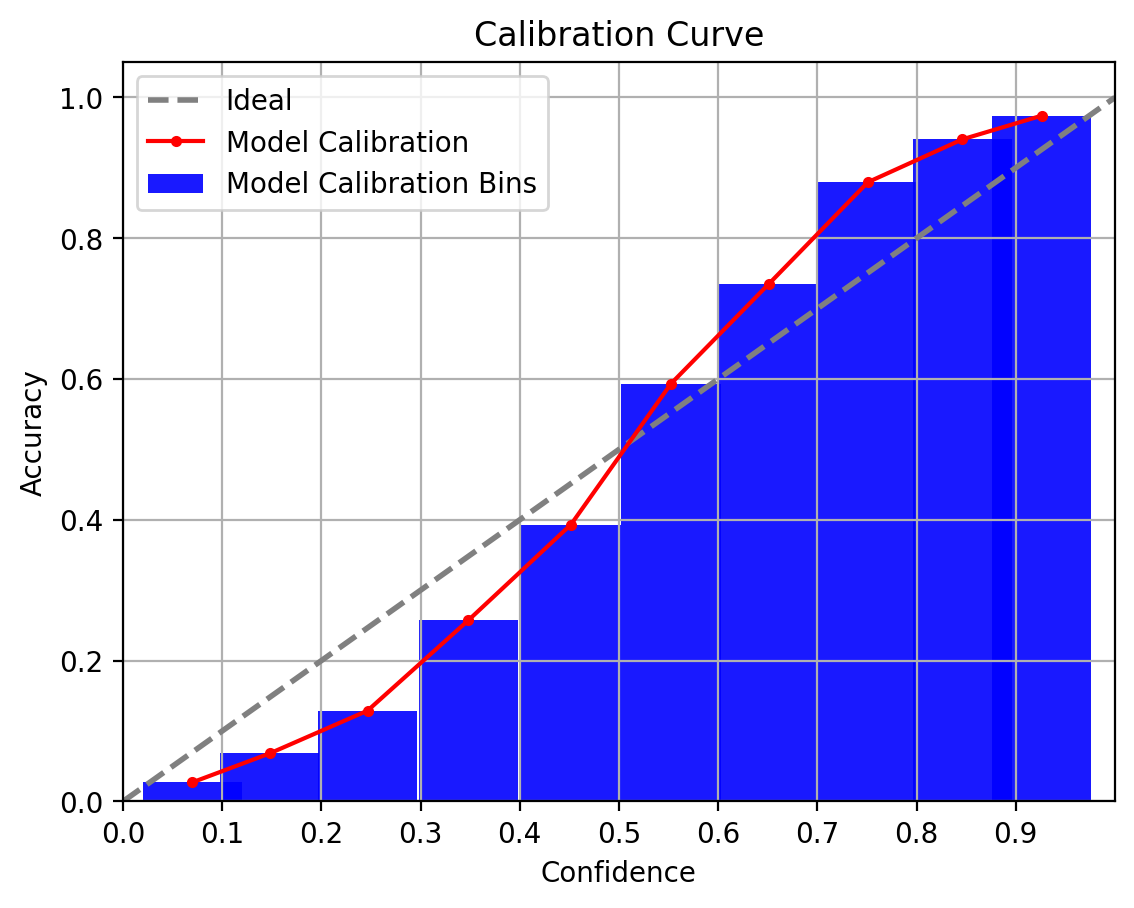

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.0842794306145774
----------------------------------------------------------------------
-------------- Training for temperature = 1.5 --------------


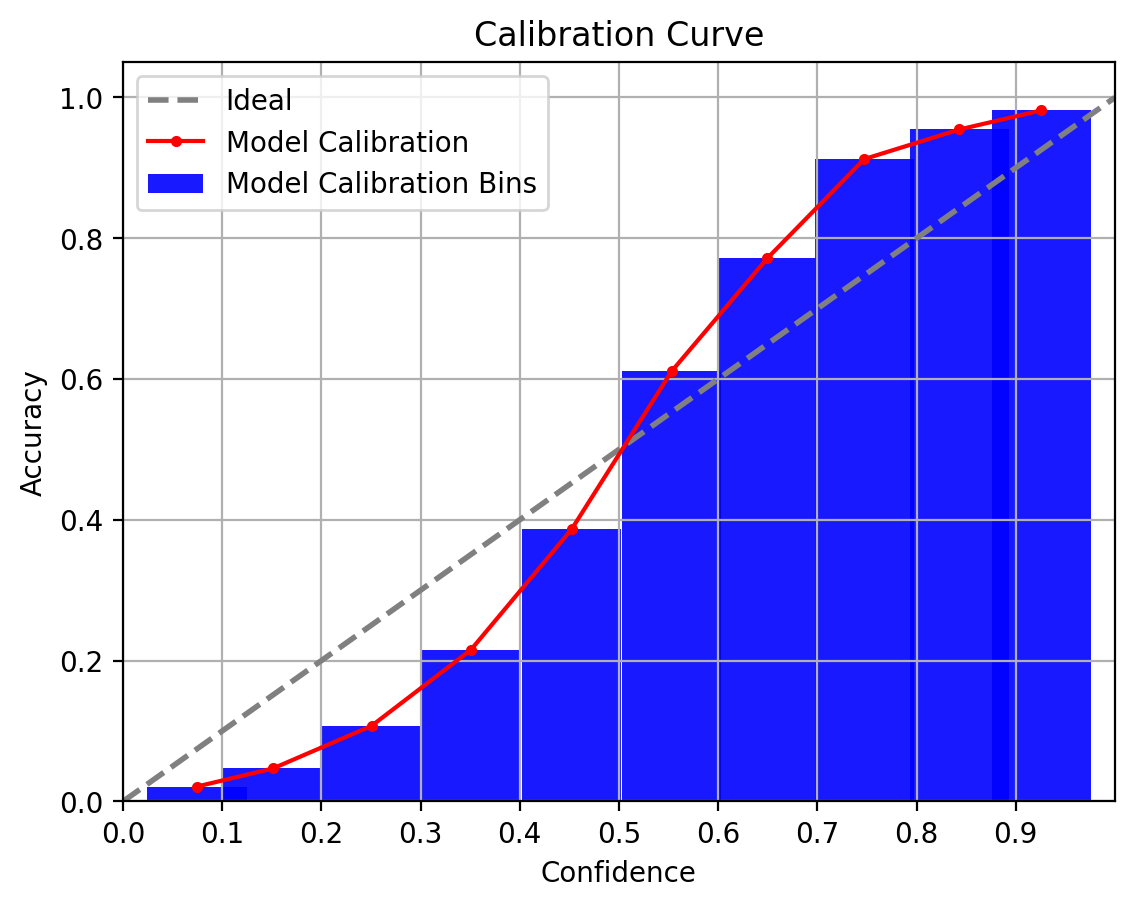

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.1131655307941967
----------------------------------------------------------------------
-------------- Training for temperature = 1.75 --------------


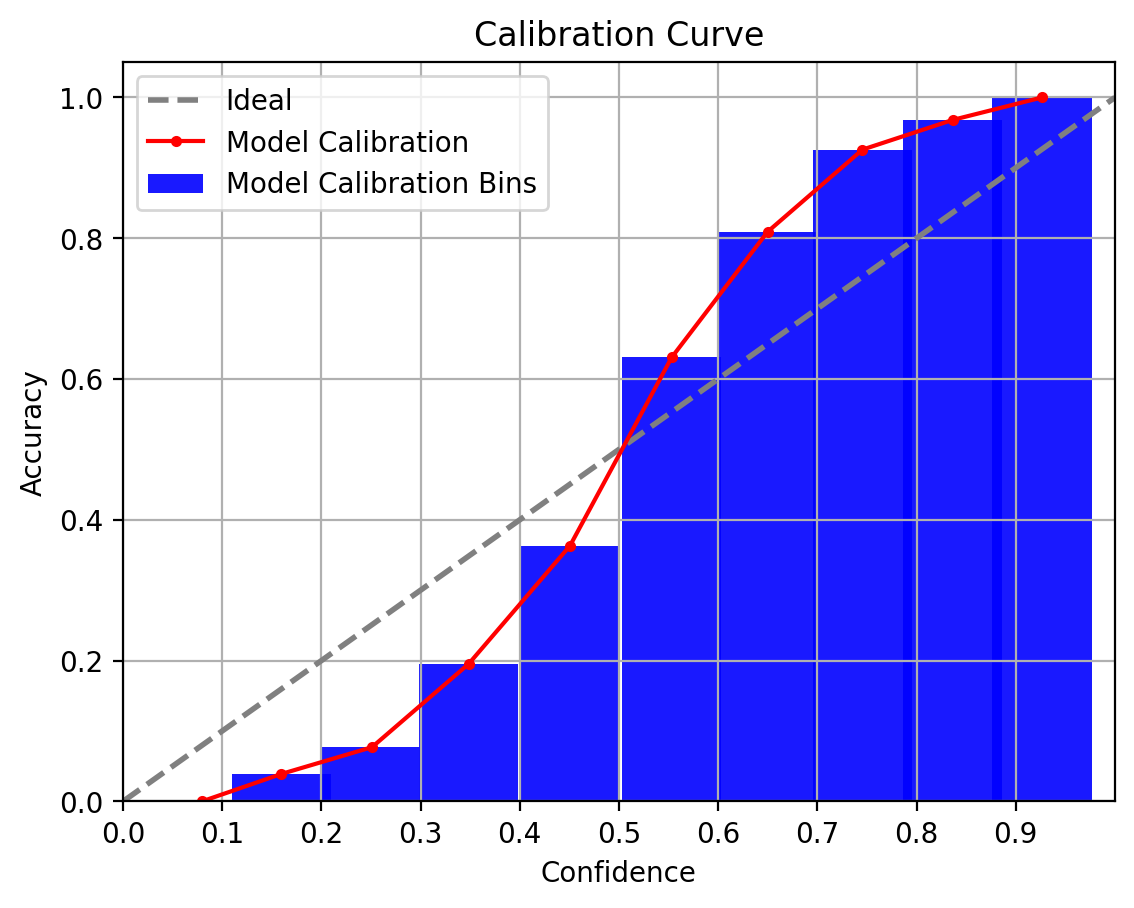

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.13641937988996505
----------------------------------------------------------------------
-------------- Training for temperature = 2.0 --------------


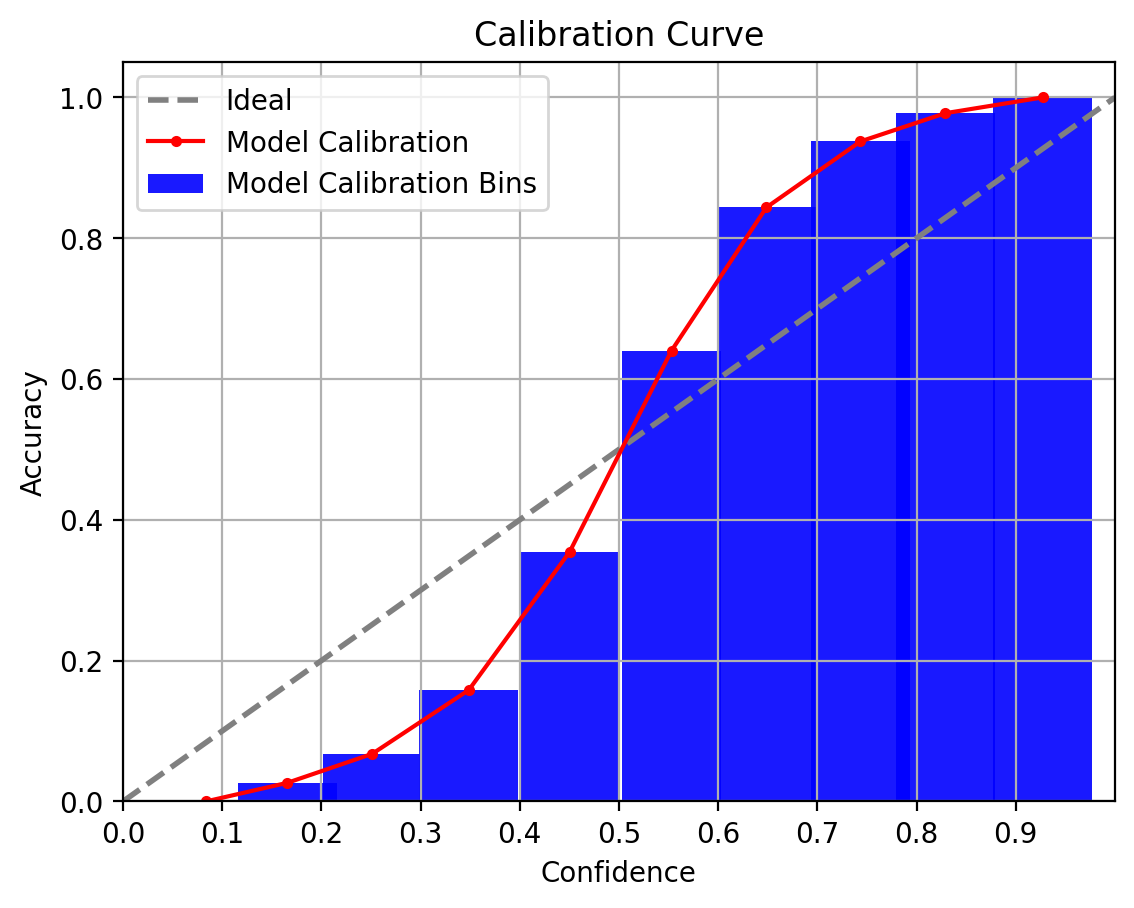

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.15537329947286183
----------------------------------------------------------------------


In [ ]:
temperatures = np.append(np.linspace(0.5, 1.0, num=6), np.linspace(1.25, 2, num=4))
temperatures = [round(num, 2) for num in temperatures]
results_temp = {}
ece_temp = {}
for temperature in temperatures:
  print(f'-------------- Training for temperature = {temperature} --------------')
  temp_CNN = Tempscaling(my_CNN, Calibration_evaluation, temperature=temperature)

  temp_CNN.calibration.plot_reliabilitydiagram(trainloader, M=10)
  ece_temp[str(temperature)] = temp_CNN.calibration.expected_calibration_error(trainloader, M=15)
  print(f'Expected Calibration error: {ece_temp[str(temperature)]}')
  print(f'----------------------------------------------------------------------')

We can see that with $T<1$ and $T\to 0$ the calibration curve in the interval $(1/K, 1]$, in this case $1/2$, tends to bowing upward and the rest of the curve tends to bowing downward. With $T>1$ and as $T\to \infty$ we can see the opposite effect, the curve in the interval $(1/K, 1]$ tends to bowing downward and the rest of the curve tends to bowing upward.

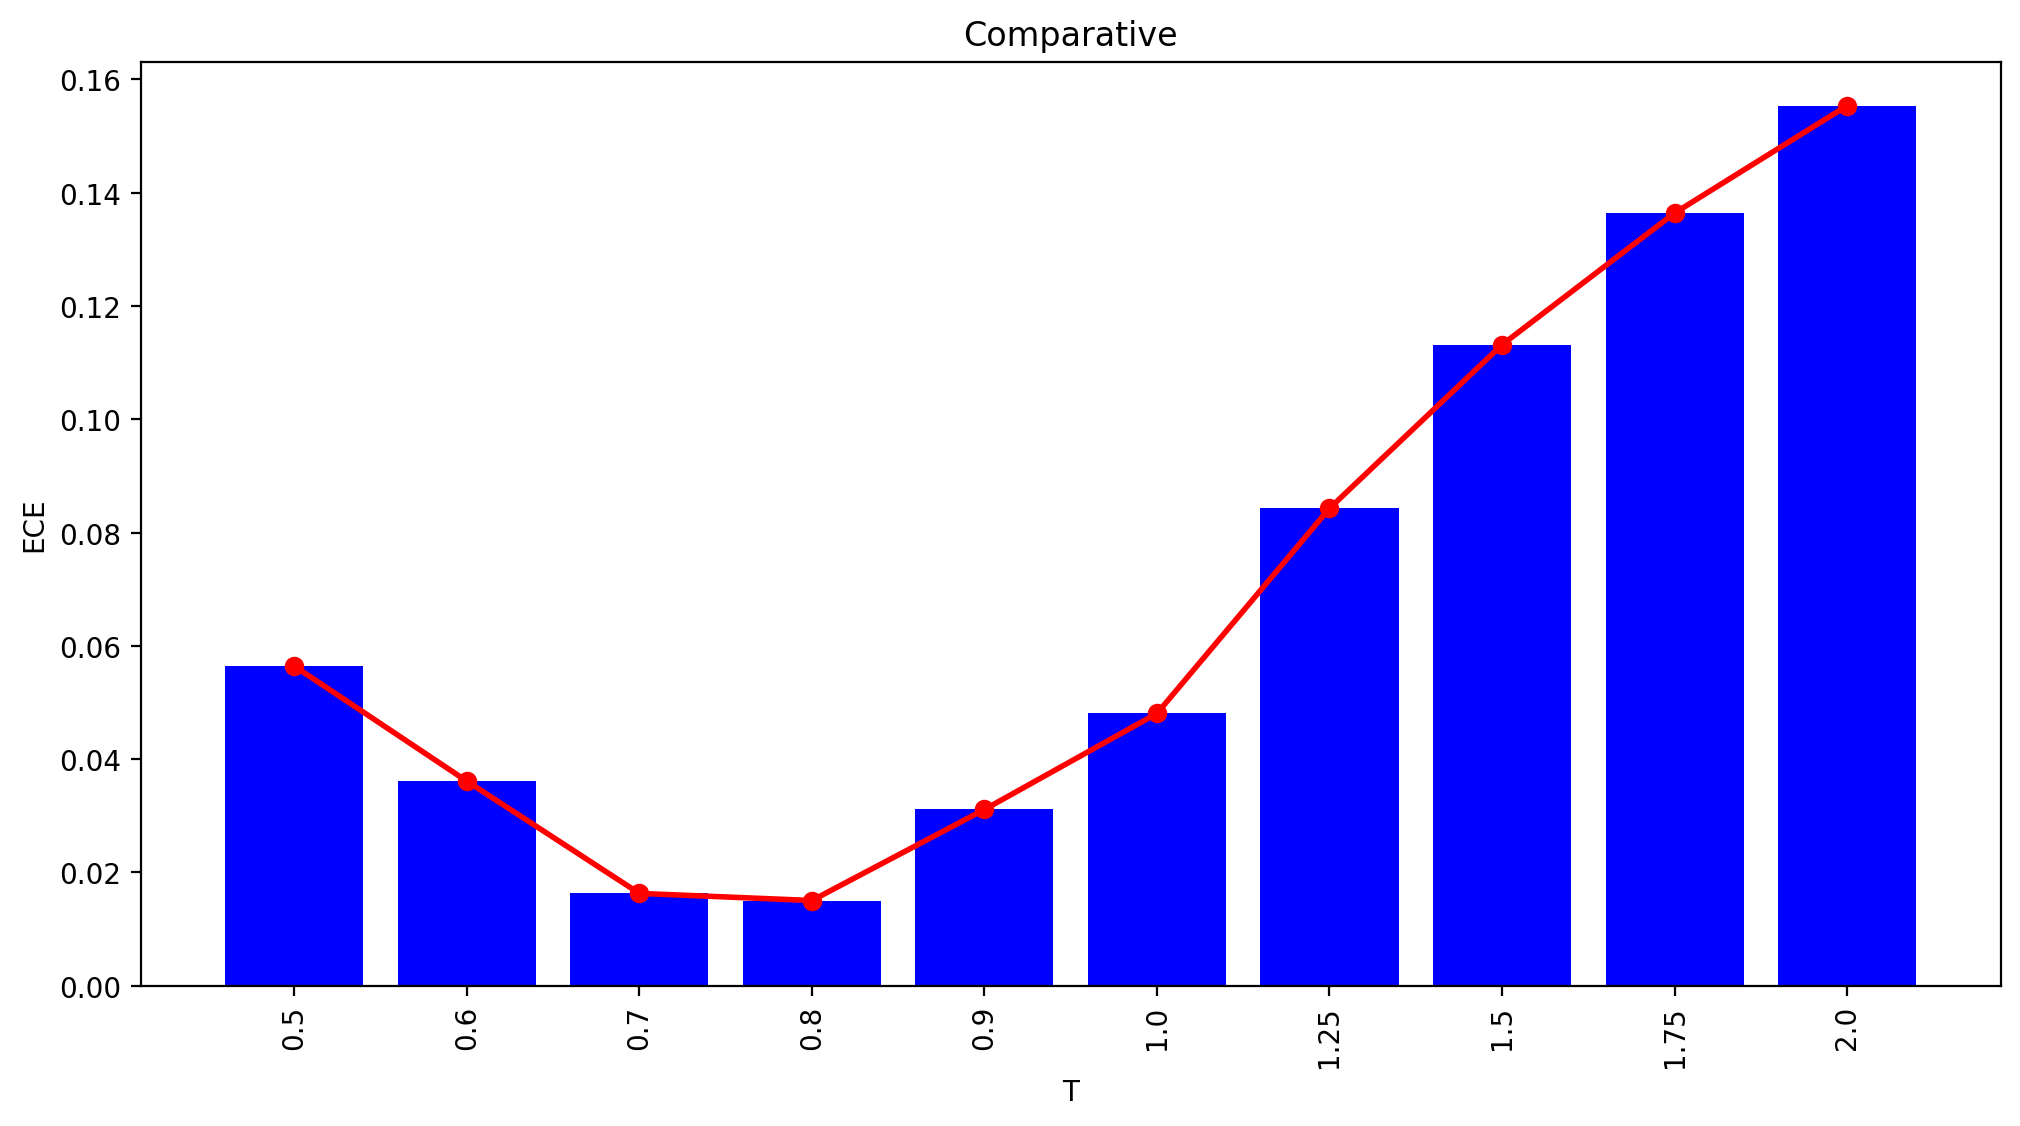

In [ ]:
plt.figure(figsize=(12,6))
for temperature in temperatures:
  plt.bar(str(temperature), ece_temp[str(temperature)], color ='blue')
sorted_ece_values = [ece_temp[str(temp)] for temp in temperatures]
plt.plot(range(len(temperatures)), sorted_ece_values, color='red', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Comparative')
plt.xticks(rotation=90)
plt.xlabel('T')
plt.ylabel('ECE')
plt.show()

We can see how by checking all the values, it seems that there is a unique minima for the ECE, and that our optimal value or sweetspot is around $T ∈ [0.7, 0.85]$

## 4. (Optional part) Repeat the experiment with a more complex model

In [ ]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We now need to replace the classifier with a MLP binary classifier:

In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx=1024, nlabels=2):

        super().__init__()

        # Dense Layers
        self.linear1 = nn.Linear(dimx,120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 2)

        # Tanh activation function
        self.relu = nn.ReLU()

        # Softmax activation function
        self.softmax = nn.Softmax(dim=1)

        # Dropout module
        self.dropout = nn.Dropout(p=0.5)

        # Batch normalization layers
        self.BN = nn.BatchNorm1d(120)

        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.linear1(x)
        x = self.BN(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

Replace the classifier of the DenseNet by the MLP

In [ ]:
for param in model.parameters():
    param.requires_grad = False

classifier = MLP(1024)

model.classifier = classifier

In [ ]:
class Tran_Eval():

    def __init__(self,model,maxiter=500,lr=0.001):

        model.softmax = nn.Softmax(dim=1)
        model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.CrossEntropyLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):


            images,labels = next(it_images)

            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()

            out = self.model.forward(images)

            loss = self.criterion(out,labels)

            running_loss = loss.item()

            loss.backward()

            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))


    def eval_performance(self,dataloader,num_batches):

        accuracy = 0

        it_images = iter(dataloader)
        with torch.no_grad():

            self.model.eval()

            for e in range(int(num_batches)):

                print('Batch %d of %d' %(e,num_batches))

                images,labels = next(it_images)

                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.model.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/num_batches


In [ ]:
model_with_train = Tran_Eval(model,maxiter=100)

In [ ]:
model_with_train.trainloop(trainloader)

Batch 0 of 100 finished. Loss 0.795312
Batch 1 of 100 finished. Loss 0.666110
Batch 2 of 100 finished. Loss 0.752635
Batch 3 of 100 finished. Loss 0.702673
Batch 4 of 100 finished. Loss 0.730504
Batch 5 of 100 finished. Loss 0.719712
Batch 6 of 100 finished. Loss 0.692544
Batch 7 of 100 finished. Loss 0.690237
Batch 8 of 100 finished. Loss 0.656997
Batch 9 of 100 finished. Loss 0.670614
Batch 10 of 100 finished. Loss 0.694232
Batch 11 of 100 finished. Loss 0.666745
Batch 12 of 100 finished. Loss 0.734472
Batch 13 of 100 finished. Loss 0.619598
Batch 14 of 100 finished. Loss 0.613083
Batch 15 of 100 finished. Loss 0.737583
Batch 16 of 100 finished. Loss 0.629200
Batch 17 of 100 finished. Loss 0.614714
Batch 18 of 100 finished. Loss 0.576567
Batch 19 of 100 finished. Loss 0.570855
Batch 20 of 100 finished. Loss 0.645874
Batch 21 of 100 finished. Loss 0.660672
Batch 22 of 100 finished. Loss 0.606211
Batch 23 of 100 finished. Loss 0.629166
Batch 24 of 100 finished. Loss 0.615157
Batch 25 o

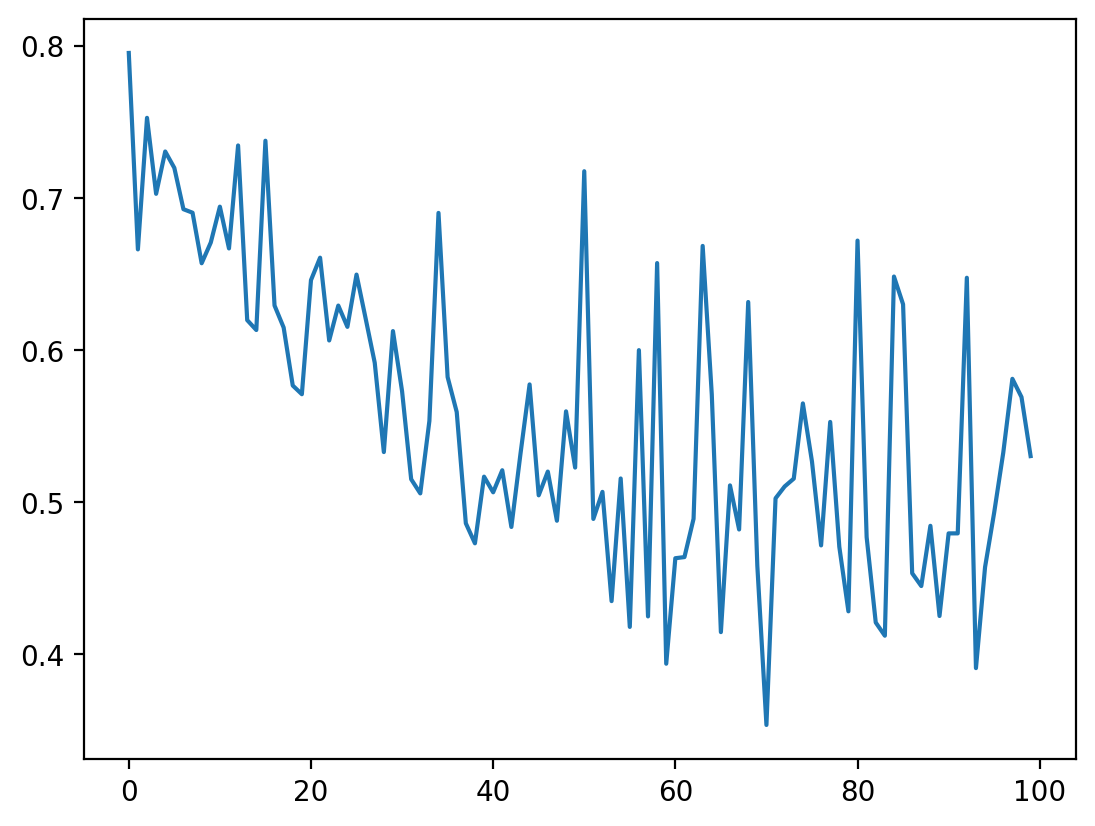

In [ ]:
plt.plot(model_with_train.loss_during_training,label='Training Loss')

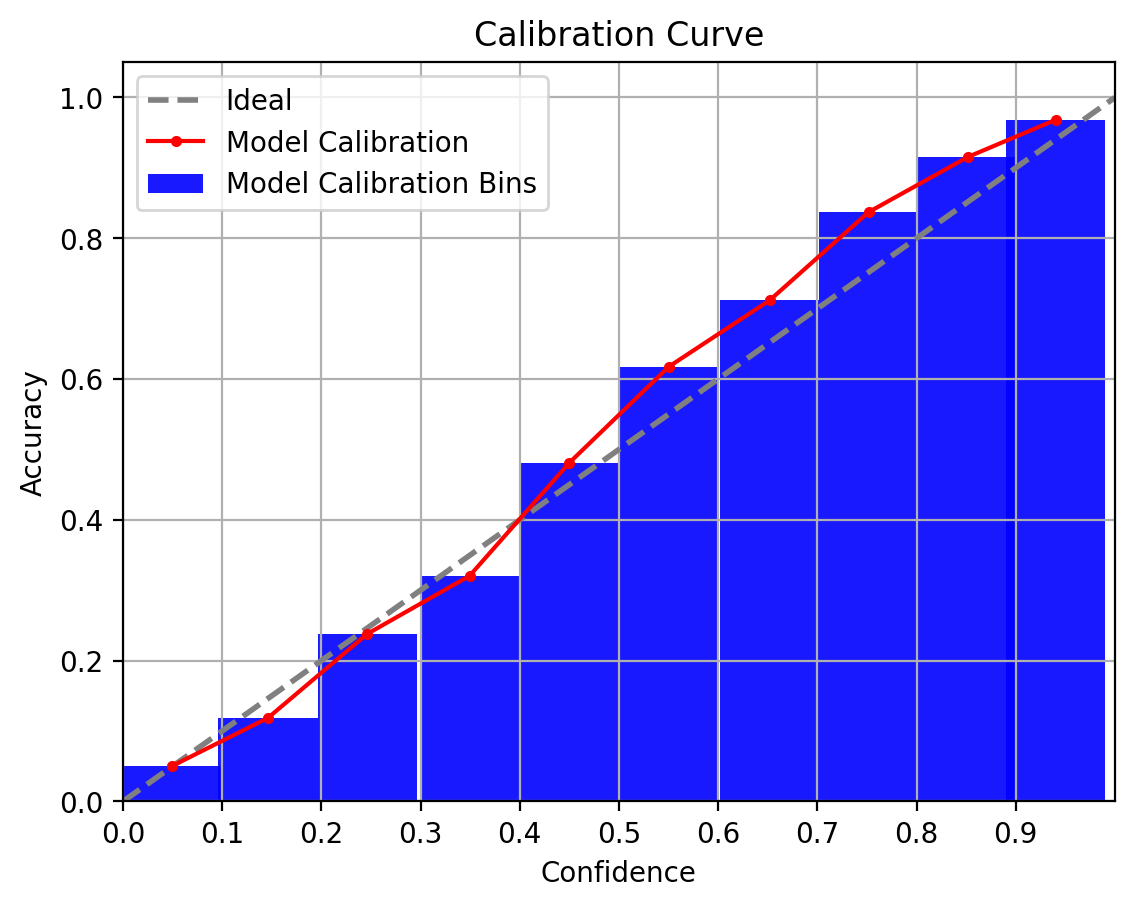

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.03325199639134933


In [ ]:
temp_dense = Tempscaling(model_with_train.model, Calibration_evaluation, temperature=1)
temp_dense.calibration.plot_reliabilitydiagram(trainloader, M=10)
print(f'Expected Calibration error: {temp_dense.calibration.expected_calibration_error(trainloader, M=15)}')

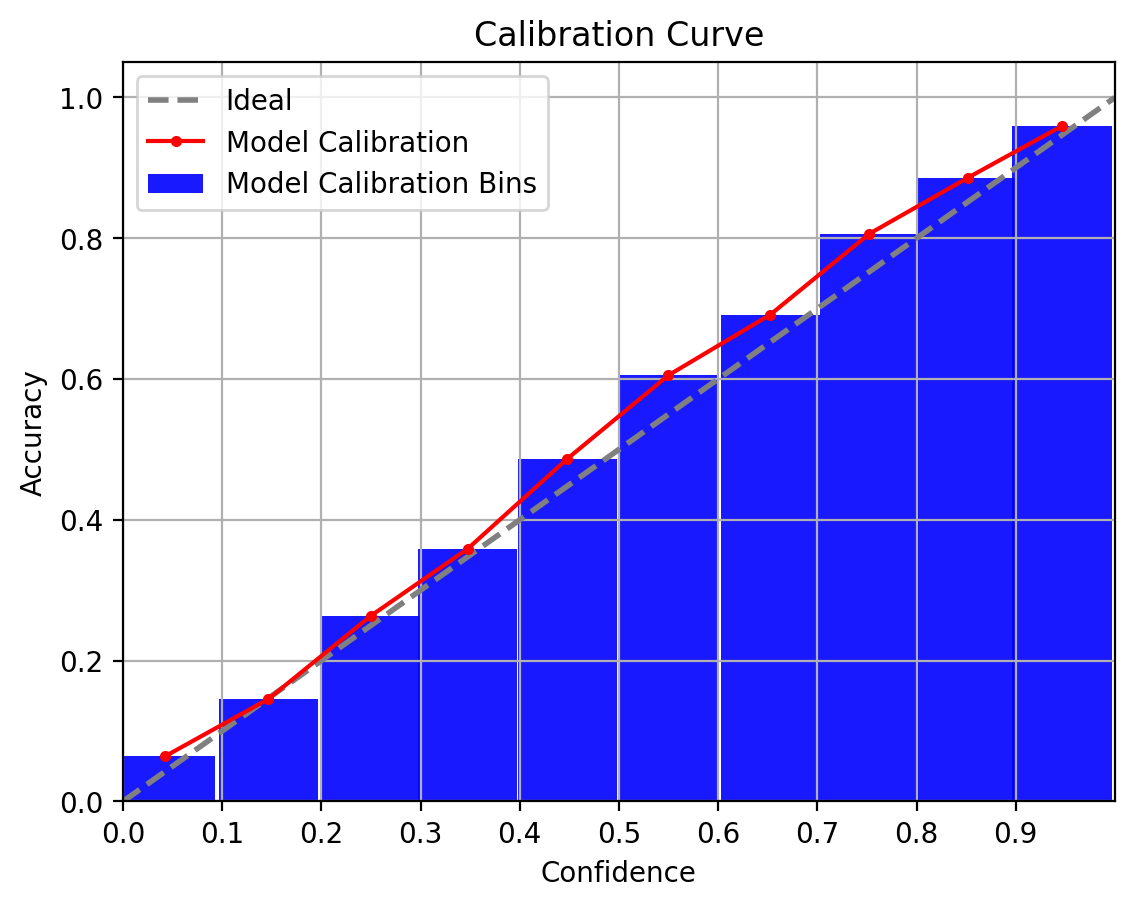

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Expected Calibration error: 0.013403401083416424


In [ ]:
temp_dense = Tempscaling(model_with_train.model, Calibration_evaluation, temperature=0.85)
temp_dense.calibration.plot_reliabilitydiagram(trainloader, M=10)
print(f'Expected Calibration error: {temp_dense.calibration.expected_calibration_error(trainloader, M=15)}')
